# Tarea 1: Activaciones y pasada hacia adelante en una red neuronal <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: 
Fecha de entrega: 6 de septiembre de 2021

In [ ]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch 
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente
# !pip install -q ipdb
# import ipdb

# Aqui instalamos la libreria de correccion del curso
!pip install "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-ygciurha/cc6204_529a961e11be4af7a84aec847a173307
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-ygciurha/cc6204_529a961e11be4af7a84aec847a173307
  Created wheel for cc6204: filename=cc6204-0.5.0-py3-none-any.whl size=5800 sha256=534a78218a241772ab110c6efa03168c755831264bda4d75b4503c1ba5ef0a29
  Stored in directory: /tmp/pip-ephem-wheel-cache-5zmcitle/wheels/3c/26/f5/2abeb546c3ff1ab6e69113a3ae69bc0ac3442642727fd0dcc2
Successfully built cc6204


In [ ]:
# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# ingresa el host y port que posteamos en u-cursos

corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# anota el token que te daremos en u-cursos

token = "]ye/Ox;nsz"

Connection stablished


# Parte 1: Funciones de activación y función de salida

## 1a) Funciones de activación

In [ ]:
def sig(T):
  return torch.reciprocal(1 + torch.exp(-1 * T))

def tanh(T):
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

# Tu código acá
def relu(T, x=0):
  t = torch.zeros_like(T)
  return torch.maximum(t,T)

def swish(T, beta):
  return T*sig(beta*T)

def celu(T, alpha):
  return torch.where(T>0, T, alpha*(torch.exp(T/alpha) - 1))

In [ ]:
# Tests del API del curso
test_relu = corrector.get_test_data(homework=1, question="1a", test=1, token=token)
test_swish, swish_par = corrector.get_test_data(homework=1, question="1a", test=2, token=token)
test_celu, celu_par = corrector.get_test_data(homework=1, question="1a", test=3, token=token)

# probablemente quieras convertr los variables test_* a un tensor, ya que por defecto son listas

corrector.submit(homework=1, question="1a", test=1, token=token, answer=relu(torch.tensor(test_relu)))
corrector.submit(homework=1, question="1a", test=2, token=token, answer=swish(torch.tensor(test_swish), swish_par))
corrector.submit(homework=1, question="1a", test=3, token=token, answer=celu(torch.tensor(test_celu), celu_par))

Correct Test!
Correct Test!
Correct Test!


## 1b) Softmax

Demostración:

$\text{softmax}(x_1,\ldots,x_n)$ = $(s_1,\ldots,s_n)$ donde:
\begin{equation}
s_i = \frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}}
\end{equation}
Definimos $\text{softmax}(x_1-M,\ldots,x_n-M) = (r_1,\ldots, r_n)$ donde:
\begin{equation}
r_i = \frac{e^{x_i-M}}{\sum_{j=1}^{n}e^{x_j-M}}
\end{equation}
Luego, para un $i$ cualquiera:
\begin{equation}
r_i = \frac{e^{x_i-M}}{\sum_{j=1}^{n}e^{x_j-M}} =
\frac{e^{x_i}\cdot e^{-M}}{\sum_{j=1}^{n}e^{x_j}\cdot e^{-M}} = 
\frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}} = s_i
\end{equation}
Por lo tanto, 
\begin{equation}
\forall i, r_i = s_i \Rightarrow \text{softmax}(x_1-M,\ldots,x_n-M) = \text{softmax} (x_1,\ldots,x_n)
\end{equation}


In [ ]:
# Función softmax
def softmax(T, dim, estable=True):
  T -= torch.max(T)
  return (torch.exp(T)/torch.sum(torch.exp(T),dim,True))

In [ ]:
# Tests del API del curso
test_softmax, _dim = corrector.get_test_data(homework=1, question="1b", test=1, token=token)
corrector.submit(homework=1, question="1b", test=1, token=token, answer=softmax(torch.tensor(test_softmax), dim=_dim))

Correct Test!


# Parte 2: Red neuronal y pasada hacia adelante (forward)

## 2a) Clase para red neuronal, 2b) Iterando por parametros, 2d) Pasada hacia adelante

In [ ]:
# Definición clase FFNN, que crea una red neuronal con pasada feed forward

class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, l_p, C):
    super(FFNN, self).__init__()
    
    #Crear parametros
    self.F = torch.nn.Parameter(torch.randn(F))
    self.weights = torch.nn.ParameterList([torch.nn.Parameter(torch.randn(F, l_h[0]))])
    self.weights.extend([torch.nn.Parameter(torch.randn(l_h[i], l_h[i+1])) for i in range(len(l_h) - 1)])
    self.bias = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros(l_h[i])) for i in range(len(l_h))])
    self.functions = l_a
    self.function_params = l_p
    self.U = torch.nn.Parameter(torch.randn(l_h[-1], C))
    self.c = torch.nn.Parameter(torch.zeros(C))
  
  def resumen(self):
    # Usa self.parameters() o self.named_parameters().
    for i in self.named_parameters():
      print(i[0] + " de dimensiones: " + str(i[1].size()))
  
  def forward(self, x, device ='cuda'):
    # Usa los parámetros y funciones de activación.
    # El valor de retorno debiera ser y = softmax(capa_de_salida).
    s = x.to(device)
    self.to(device)
    for i in range(len(self.weights)):
      s = self.functions[i](s @ self.weights[i] + self.bias[i], self.function_params[i])
    s = (s @ self.U + self.c)
    return softmax(s,-1)

  # Le pasa los valores pre-entrenado a la red
  def init_weights(self, W, b, u, C):
    for i in range(len(W)):
      self.weights[i] = torch.nn.Parameter(W[i])
    for i in range(len(b)):
      self.bias[i] = torch.nn.Parameter(b[i])
    self.U = torch.nn.Parameter(u)
    self.c = torch.nn.Parameter(C)
    


## 2c) Moviendo los parámetros entre dispositivos

In [ ]:
# Tu código acá
red_neuronal = FFNN(300,[50,30],[relu,sig], [1,1], 10)
red_neuronal.to('cuda')
!nvidia-smi

Sun Oct 10 15:34:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    74W / 149W |    494MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Parte 3: Probando tu red con parámetros pre-entrenados para MNIST

In [ ]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
# Importamos funcionalidades útiles para mirar los datos.
from matplotlib.pyplot import subplots
from random import randint

# Descarga y almacena el conjunto de prueba de MNIST.
dataset = MNIST('mnist', train=False, transform=ToTensor(), download=True)
print('Cantidad total de datos:',len(dataset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw

Cantidad total de datos: 10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 3b) Cargando los parámetros pre-entrenados

In [ ]:
# Se importan los datos pre-entrenados
!wget -N https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea1/mnist_weights/U.txt
!wget -N https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea1/mnist_weights/W1.txt
!wget -N https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea1/mnist_weights/W2.txt
!wget -N https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea1/mnist_weights/b1.txt
!wget -N https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea1/mnist_weights/b2.txt
!wget -N https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea1/mnist_weights/c.txt

# Se guardan los datos en variables
from numpy import loadtxt
U = torch.from_numpy(loadtxt('U.txt')).float()
W1 = torch.from_numpy(loadtxt('W1.txt')).float()
W2 = torch.from_numpy(loadtxt('W2.txt')).float()
b1 = torch.from_numpy(loadtxt('b1.txt')).float()
b2 = torch.from_numpy(loadtxt('b2.txt')).float()
c = torch.from_numpy(loadtxt('c.txt')).float()

# Se inicializa una red con los parámetros correspondientes a los datos pre-entrenados
# y luego se le pasan los datos a la red
red = FFNN(784, [32, 16], [relu, relu], [0,0], 10)
red.init_weights([W1, W2], [b1, b2], U, c)


--2021-10-10 15:34:56--  https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea1/mnist_weights/U.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4099 (4.0K) [text/plain]
Saving to: ‘U.txt’

U.txt               100%[===================>]   4.00K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2021-10-10 15:34:56 (47.0 MB/s) - ‘U.txt’ saved [4099/4099]

--2021-10-10 15:34:57--  https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea1/mnist_weights/W1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP re

## 3c) Calcula la predicción de un ejemplo al azar

test 0: 0
test 1: 1
test 6: 6


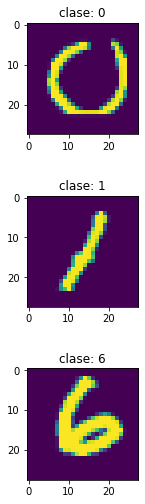

In [ ]:
# Muestra algunos ejemplos al azar
n_ejemplos = 3
fig, axs = subplots(nrows=n_ejemplos, figsize=(2,n_ejemplos*3))

# Se calculan los ejemplos al azar y muestra si se acertó o no
for i in range(n_ejemplos):  
  idx = randint(0,len(dataset))
  T, l = dataset[idx]
  img = T.view(28,28).numpy()
  axs[i].set_title("clase: "+ str(l))
  axs[i].imshow(img)
  result = torch.argmax(red.forward(torch.flatten(T)), dim=0)
  print("test " + str(l) + ": " + str(result.item()))


## 3d) Pasando todos los ejemplos por la red con un `DataLoader`

In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=100)

# Función que calcula porcentaje de acierto de la red
def calcula_acierto(red, dataset, batch_size=100, device='cuda'):
  buenos = 0
  for x, y in dataset:
    result = torch.argmax(red.forward(torch.flatten(x), device=device), dim=0)
    if result.item() == y:
      buenos+=1
  return buenos/len(dataset)

porcentaje = calcula_acierto(red, dataset)*100
print(f"{porcentaje} % de acierto")

96.12 % de acierto


### Corrección red

In [ ]:
# Tests del API del curso
from torch.utils.data import Subset
indices = corrector.get_test_data(homework=1, question="network", test=1, token=token)
test_set = Subset(dataset, indices)

# Modelo con los parámetros pre-entrenados para MNIST
your_network = FFNN(784, [32, 16], [relu, relu], [0,0], 10)
your_network.init_weights([W1, W2], [b1, b2], U, c)

# Montar el `test_set` en un tensor de (N, 28*28) usando DataLoader
X = list(DataLoader(test_set, batch_size=len(test_set)))[0][0].view(-1, 28*28)

# Almacenar el resultado en un puro tensor de (N,1)
result = torch.argmax(your_network(X), dim=1)

corrector.submit(homework=1, question="network", test=1, token=token, answer=result)

Correct Test!


## 3e) Opcional: Muestra los casos en donde la red se equivoca

In [ ]:
# Acá tu código

## 3d) Opcional: Crea tus propios ejemplos de dígitos para clasificar

In [ ]:
# Acá tu código